<a href="https://colab.research.google.com/github/PavelFili/hello-world/blob/master/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22CV2_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Семинар 2

В этом семинаре вы познакомитесь с концепцией глубокого обучения в контексте задачи компьютерного зрения

## Почему вам будет полезен этот семинар:
1. Поработаете с реальными датасетами для задачи компьютерного зрения
2. Узнаете о такой проблеме нейронных сетей, как переобучение, и о том, как с ней бороться
3. Научитесь правильно переиспользовать уже обученные нейронные сети

## 1) CIFAR10

**CIFAR-10** - один из стандартных датасетов для задач классификации картинок.
Датасет содержит $60000$ цветных фото объектов $10$ классов: "самолет", "автомобиль", "птица", "кошка", "олень", "собака", "лягушка", "лошадь", "корабль", "грузовик".
Изображения в **CIFAR-10** имеют размер $3\text{x}32\text{x}32$ то есть это $\text3$-канальные цветные изображения размером $32\text{x}32$ пикселя.



<img src="https://pytorch.org/tutorials/_images/cifar10.png" alt="CIFAR10_dataset" width="500" align="left"/>

### Пререквизиты
Установим и загрузим необходимые библиотеки

In [ ]:
# Импортируем torch, torchvision
import torch
import torchvision
# Импортируем модуль transforms для предобработки данных
import torchvision.transforms as transforms
# Импортируем класс Dataloader для получения данных из датасета
from torch.utils.data import DataLoader
# Импортируем модуль nn для создания и работы с нейронными сетями
from torch import nn
# Импортируем модуль, который покажет слои и количество параметров модели
from torchsummary import summary


# Импортируем numpy для работы с массивами данных и matplotlib для визуализации данных
import numpy as np
from matplotlib import pyplot as plt


# Для воспроизводимости "замораживаем сиды"
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Utils

Здесь некоторые дополнительные функции, которые облегчат нам работу с данными.

In [ ]:
def plot_CIFAR_samples(image_data, label_data, classes,  N=8):
    """
        Эта функция строит N самплов каждого класса из датасета image_data

        Параметры
        ----------
        image_data : array
            Array of shape
            (number_of_samples, image_width, image_height, number of channels)
            with images
        label_data : array
            Array of shape
            (number_of_samples, )
            with labels
        classes : list
            list with classes names
        dataset_name : str
            Name of dataset to write in the title
        N : int
            Number of samples for each class
    """
    plt.figure(figsize=(10,N))
    num_classes = len(classes)
    for class_indx, y in enumerate(classes):
        idxs = np.flatnonzero(np.equal(label_data, class_indx))
        idxs = np.random.choice(idxs, N, replace=False)
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + class_indx + 1
            plt.subplot(N, num_classes, plt_idx)
            plt.imshow(image_data[idx], cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title(str(y))
    plt.show()

In [ ]:
def plot_CIFAR_grid(dataloader, N=8, unnormalize=False):
    """
    Эта функция строит сетку NхN примеров из переданного даталоадера

    Параметры
    ----------
    dataloader : torch.utils.data.DataLoader class
        Dataloader returns a batch of images and labels
    classes : list
        List of classes
    N : int
        Number of samples for each class
    unnormalize : bool
        Unnormalize images if True
    """
    plt.figure(figsize=(N,N))
    plt_index = 1
    for batch_images, batch_labels in dataloader:
        if plt_index > N*N:
            break
        batch_images = batch_images.permute(0,2,3,1).numpy()
        batch_labels = batch_labels.numpy()
        if unnormalize:
            batch_images = batch_images / 2 + 0.5

        for image, label in zip(batch_images, batch_labels):
            if plt_index == N*N + 1:
                break
            plt.subplot(N, N, plt_index)
            plt.imshow(image)
            plt.axis("off")
            plt_index+= 1

### Загрузка датасета CIFAR10

Датасет уже встроен в библиотеку `torch`. Загрузим его, сделаем небольшую предобработку(нормализацию изображений), сохраним в директорию `./data` и посмотрим на содержание выборки.

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 128

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

trainloader = DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

100%|██████████| 170498071/170498071 [00:12<00:00, 13238171.97it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


Также подгрузим данные для тестового датасета

In [ ]:
testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

testloader = DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

Files already downloaded and verified


Также напишем названия классов

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# classes = ("самолет", "автомобиль", "птица", "кошка", "олень",
#            "собака", "лягушка", "лошадь", "корабль", "грузовик")

Посмотрим на содержание датасета, вызвав функцию plot_CIFAR_samples которая строит на одной картинке N примеров каждого класса

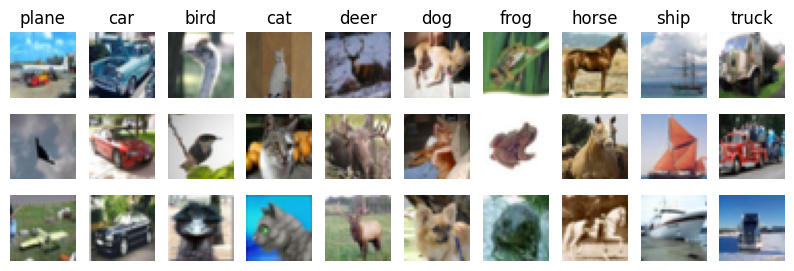

In [ ]:
plot_CIFAR_samples(testloader.dataset.data, testloader.dataset.targets, classes,  N=3)

В переменной `transforms` мы заранее указываем какие преобразования с изображениями нужно сделать: с помощью метода `ToTensor()` изображения переводятся в класс `torch.FloatTensor` и значения пикселей переводятся из диапазона  [0, 255] в диапазон  [0,1] (важно отметить, что масштабирование значений происходит только если исходные данные целочисленные в формате int, если данные в формате float, они не будут изменены), метод `Normalize()` приведёт данные к стандартному нормальному распределению с математематическим ожиданием 0.5 и среднеквадратическим отклонением 0.5 для каждого из каналов изображения.
Давайте посмотрим, как изменилось распределение интенсивности пикселей.

**Вопрос 1** Почему стоит нормировать изображения, поступающие на вход нейронной сети?\
**Вопрос 2** Какие взять значения для среденеквадратического отклонения и мат. ожидания?

Ниже приведен пример распределения интенсивности пикселей 3-х канального изображения до и после нормализации. Исходная интенсивность пикселей находится в интервале [0, 1]

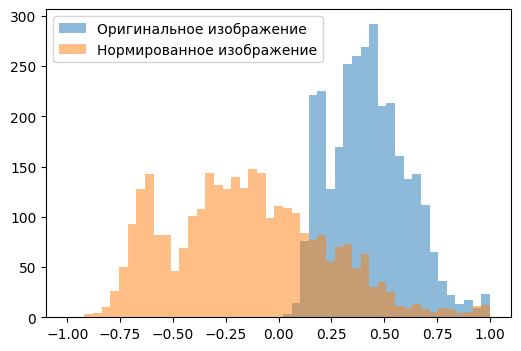

In [ ]:
image = testloader.dataset[0][0]
orig_image = image / 2 + 0.5
bins = np.linspace(-1, 1, 50)

plt.figure(figsize=(6,4))
plt.hist(orig_image.flatten(), bins=bins, alpha=0.5, label='Оригинальное изображение ')
plt.hist(image.flatten(), bins=bins, alpha=0.5, label='Нормированное изображение')
plt.legend(loc='best')
plt.show()

### Сверточный слой ( Conv layer)
В семинаре мы будем использовать сверточные нейронные сети. Слой такой сети состоит из **ядра** - окна с весами, которое последовательно проходит по пикселям входящего изображения (на картинке движется ядро размером $3\text{x}3$) и складывает их с соответствующими весами.

<table>
  <tr>
    <td>
      <img src="https://neurohive.io/wp-content/uploads/2018/07/convolutional-neural-network.gif" alt="Изображение 1" width="400">
    </td>
    <td>
      <img src="https://neurohive.io/wp-content/uploads/2018/07/2d-covolutions.gif" alt="Изображение 2" width="400">
    </td>
  </tr>
</table>

<table>
  <tr>
    <td>
      <img src="https://i.stack.imgur.com/YDusp.png" width="800" align="center" alt="Изображение 3">
  </tr>
</table>


Таким образом, использование сверток помогает извлекать паттерны на картинке.

Экспериментальные данные показывают, что более глубокие слои распознают более сложные закономерности на картинке. Например, первые слои обычно выучивают фильтры на прямые линии под разными углами, дальше уже могут выучиваться фильтры на конкретные детали, например глаза или фары машины.

<img src="https://www.researchgate.net/publication/334683018/figure/fig1/AS:784609059041284@1564076785945/The-lower-level-features-progressively-combine-to-form-higher-layer-features-in-deep.ppm" width="300" align="center" alt="Пример работы сверточного слоя" >


### MaxPool layer

Слой, похожий на свертку, но вместо суммирования элементов входного изображения с весами ядра, этот слой внутри перемещающегося окна выбирает максимальный элемент и передает его дальше.

Обычно слои **Conv** и **MaxPool** используют в паре, **MaxPool** используется для уменьшения размерности данных.

**Пример работы MaxPool слоя с ядром (2,2)**

<img src="https://i2.wp.com/miro.medium.com/0*yaD1ysnftg0DZCe0"
     width="300" align="center" alt="Принцип работы MaxPooling" >

### Baseline

Построим сверточную нейросеть из нескольких блоков уже существующей нейросети **VGG**. Один блок включает 2 свёрточных слоя и слой max pooling для уменьшения размерности: **conv-conv-maxpool**.

**VGG** - семейство существующих архитектур нейросетей, которые демонстрируют одни из лучших результатов в задачах выделения признаков из картинок.



<img src="https://www.researchgate.net/profile/Timea-Bezdan/publication/333242381/figure/fig2/AS:760979981860866@1558443174380/VGGNet-architecture-19.ppm" width="400" align="center" alt="Архитектура сети VGG">

<img src="https://upload.wikimedia.org/wikipedia/commons/2/24/VGG16.png" width="600" align="center" alt="Архитектура сети VGG">


Модель в библиотеке PyTorch можно построить разными способами. Например через наследование классов. В нашем случае мы будем использовать контейнер nn.Sequential. В него поместим все слои и функции активации. Данные будут проходить через него последовательно от слоя к слою.

Для подбора параметров можно ориентироваться на следующие "эвристики":
- Количество каналов определяет сколько разных фильтров выучит модель.
- Лучше больше сверток с небольшими ядрами, чем меньше сверток с большими. Это связано с тем, что окно восприятия будет примерно одинаково, но в случае меньших сверток параметров будет использовано меньше. Попробуйте убедится в этом сами на бумаге - сравните две последовательные свертки 3x3 и одну свертку 5x5.


In [ ]:
class SimpleVGG(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        # VGG1-блок

        self.block1 = nn.Sequential( # Sequential нужен, чтобы упаковать несколько подряд идущих слоев
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
        )

        # VGG2-блок
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
        )

        # Блок классификатора
        self.classifier = nn.Sequential(
            # Разворачиваем данные в вектор
            nn.Flatten(),
            # После второго  "Max-Pooling" размер карты признаков 8*8, а количество
            # выходных каналов  - 64, поэтому количество входных каналов = 8*8*64
            nn.Linear(in_features=8*8*64, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=n_classes)

        )

    # Последовательно подаем входные данные через 2 VGG слоя и классификатор
    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.classifier(out)
        return out

In [ ]:
# теперь модель нужно инициализировать
model = SimpleVGG(n_classes=len(classes))

In [ ]:
# Посмотрим, из чего наша модель состоит
summary(model, (3, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 32, 32, 32]           9,248
              ReLU-4           [-1, 32, 32, 32]               0
         MaxPool2d-5           [-1, 32, 16, 16]               0
            Conv2d-6           [-1, 64, 16, 16]          18,496
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,928
              ReLU-9           [-1, 64, 16, 16]               0
        MaxPool2d-10             [-1, 64, 8, 8]               0
          Flatten-11                 [-1, 4096]               0
           Linear-12                   [-1, 64]         262,208
             ReLU-13                   [-1, 64]               0
           Linear-14                   

### Обучение модели
**Тренировка с указанием данных, числа эпох и размера подвыборки**

Теперь задана структура модели. Мы будем итерироваться по эпохам и батчам, и параметры будут оптимизироваться градиентным спуском.
При этом мы используем функцию потерь, которая подсчитана только по части полной выборки (по батчу).

**epochs** - число эпох, сколько раз мы проходим полностью по всей выборке. Количество эпох **epochs** обычно выбирают так, чтобы метрика качества на валидационной выборке не стала убывать (то есть не произошло переобучения).


##### Алгоритм для каждой эпохи обучения:

    for epoch in range(Number_of_epochs):
      for Batch in Dataset:
        1.   Обнулить градиенты весов
        2.   Посчитать значение функции потерь на батче
        3.   Обратное распространение ошибки (посчитать градиенты для весов)
        4.   Обновить веса


Всю работу по изменению весов и градиентов производит **оптимизатор**. Создадим его и функцию потерь. В оптимизатор мы должны передать все параметры нашей модели. Функцию потерь принято называть переменной `criterion`

In [ ]:
optimizer = torch.optim.NAdam(model.parameters(), lr= 5e-4)
criterion = torch.nn.CrossEntropyLoss()

GPU позволяют обучать нейронные сети гораздо быстрее. Чтобы их использовать нужно перенести все наши переменные на GPU. Для начала определим, а есть ли он у вас:

In [ ]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
device

'cuda'

Если ячейка выше вывела 'cpu', то вы не выбрали нужные настройки в Google Collab. Нужно поменять с CPU на T4. Если вы используете данный ноутбук локально, то возможно у вас нет видеокарты от NVIDIA или нужных драйверов cuda.

Переведем нашу модель на поддерживаемый девайс. Сами данные мы будем тоже переводить на его вычислительные мощности, но уже в самом цикле обучения

In [ ]:
model.to(device)

SimpleVGG(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)

Теперь рассмотрим функцию для обучения модели

In [ ]:
# Функция обучения одной эпохи
def train_step(model, train_dataloader, optimizer):

    model.train() # Переводим модель в режим тренировки

    # Сохраняем различные статистики внутри эпохи
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Итерация по батчам в датасете
    for i, data in enumerate(train_dataloader):
        inputs, labels = data

        # Перемещение данных на GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # Обнуление градиентов.
        # Без этой строчки, торч просто добавит их к предыдущим
        optimizer.zero_grad()

        # Прямой проход
        outputs = model(inputs) # Передаем изображения в модель
        loss = criterion(outputs, labels) # Считаем функцию потерь
        loss.backward() # Применяем обратное распространение ошибки
        optimizer.step() # Делаем шаг обучения

        # Статистика для вывода
        running_loss += loss.item()
        predicted = torch.argmax(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    # Вычисление среднего значения потерь и точности на эпохе
    train_accuracy = correct_predictions / total_samples
    average_loss = running_loss / len(train_dataloader)

    return average_loss, train_accuracy

def test_step(model, test_dataloader):
    # Часть для тестирования на test выборке
    model.eval()

    # Статистика для тестирования
    test_correct_predictions = 0
    test_total_samples = 0

    # Итерация по батчам в валидационном датасете
    with torch.no_grad():  # Не считаем градиенты, так как это тестирование
        for i, data in enumerate(test_dataloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Прямой проход
            outputs = model(inputs)

            # Статистика для вывода
            predicted = torch.argmax(outputs.data, 1)
            test_total_samples += labels.size(0)
            test_correct_predictions += (predicted == labels).sum().item()

    # Вычисление точности на тестовой выборке
    test_accuracy = test_correct_predictions / test_total_samples
    return test_accuracy


# общая функция ддя обучения
def train_model(model, train_dataloader, test_dataloader, optimizer, num_epochs=8):
    #Будем складывать accuracy на каждой эпохе
    train_accuracy_history = []
    test_accuracy_history = []

    for epoch in range(num_epochs): # Итерируемся по эпохам
        # шаг обучения
        average_loss, train_accuracy = train_step(model, train_dataloader, optimizer)
        train_accuracy_history.append(train_accuracy)

        #шаг тестирования
        test_accuracy = test_step(model, test_dataloader)
        test_accuracy_history.append(test_accuracy)

        # Вывод результатов
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print(f'Loss: {average_loss:.4f} | Train Accuracy: {train_accuracy:.4f} | Test Accuracy: {test_accuracy:.4f}')

    return train_accuracy_history, test_accuracy_history

In [ ]:
num_epochs = 15
train_history, test_history = train_model(model, trainloader, testloader, optimizer, num_epochs)

Epoch 1/15
Loss: 1.6309 | Train Accuracy: 0.4114 | Test Accuracy: 0.5054
Epoch 2/15
Loss: 1.2720 | Train Accuracy: 0.5447 | Test Accuracy: 0.5913
Epoch 3/15
Loss: 1.0679 | Train Accuracy: 0.6221 | Test Accuracy: 0.6305
Epoch 4/15
Loss: 0.9312 | Train Accuracy: 0.6753 | Test Accuracy: 0.6633
Epoch 5/15
Loss: 0.8344 | Train Accuracy: 0.7084 | Test Accuracy: 0.6876
Epoch 6/15
Loss: 0.7553 | Train Accuracy: 0.7369 | Test Accuracy: 0.7073
Epoch 7/15
Loss: 0.6865 | Train Accuracy: 0.7631 | Test Accuracy: 0.7150
Epoch 8/15
Loss: 0.6263 | Train Accuracy: 0.7815 | Test Accuracy: 0.6946
Epoch 9/15
Loss: 0.5693 | Train Accuracy: 0.8011 | Test Accuracy: 0.7196
Epoch 10/15
Loss: 0.5149 | Train Accuracy: 0.8221 | Test Accuracy: 0.7258
Epoch 11/15
Loss: 0.4626 | Train Accuracy: 0.8383 | Test Accuracy: 0.7304
Epoch 12/15
Loss: 0.4163 | Train Accuracy: 0.8561 | Test Accuracy: 0.7308
Epoch 13/15
Loss: 0.3672 | Train Accuracy: 0.8709 | Test Accuracy: 0.7242
Epoch 14/15
Loss: 0.3229 | Train Accuracy: 0.88

Построим графики точности на тестовой  и трейновой выборках в конце каждой эпохи обучения, чтобы посмотреть динамику обучения.

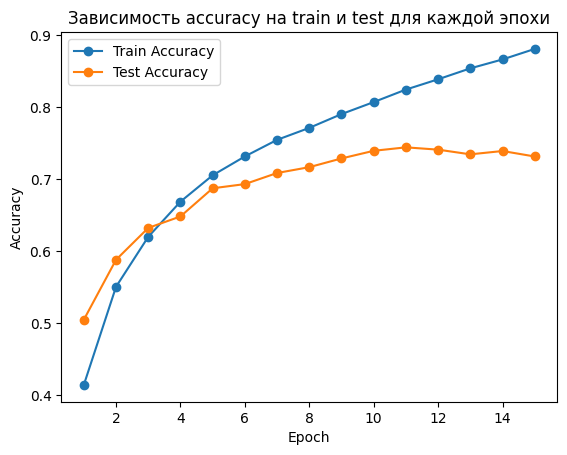

In [ ]:
plt.plot(range(1, len(train_history)+1), train_history, label='Train Accuracy', marker="o")
plt.plot(range(1, len(test_history)+1), test_history, label='Test Accuracy', marker="o")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Зависимость accuracy на train и test для каждой эпохи")
plt.legend()
plt.show()

Точность на тестовой выборке (оранжевая линия) быстро сбавляет скорость роста и уступает точности на тренировочном датасете (синяя линия), так что модель переобучается.

## 2) Переобучение.

Только что мы увидели, как модель переобучается, то есть качество работы модели перестает улучшаться на тестовых (новых) данных и модель все больше подстраивается под тренировочные данные. Для борьбы с переобученем существует несколько способов. Давайте их рассмотрим.

### Аугментация данных

Один из способов решения проблемы переобучения сети - аугментация ("увеличение") тренировочного датасета без привлечения реальных новых картинок.

Попробуем изменять наши исходные картинки перед тем, как они попадут в сетку при помощи различных трансформаций.

Конечно, можно было бы поштучно изменить каждую картинку, сохранить, как новый датасет и тренировать модель уже на нем.

Но это дает меньшую вариативность преобразований, занимает много места и памяти. Чтобы не изменять каждую картинку вручную, используют генераторы.


Для этой задачи в `transforms` можно указать, какие преобразования с исходными изображениями нужно сделать. Давайте заново создадим датасет с учетом преобразований.

Важно, что трансформация должна применяться только к тренировочным данным. **Данные для теста изменять не нужно!**

#### Задача 1. Аугментация данных

Для вас уже подготовлена ячейка с кодом, в которой нужно дописать предобработку данных для обучающей выборки.

Для обучающих данных добавьте аугментации.
Возможные аугментации (**Рекомендуем добавить первые 2**):
- **transforms.RandomResizedCrop(size=(32,32), antialias=True,  scale=(0.75, 1.0))**  # Случайно вырезает участок из изображения. 'size' - это ожидаемый выходной размер обрезанного изображения для каждого края; параметр 'scale' задает масштаб вырезанного участка;  "antialias" - следует ли применять сглаживание.
- **transforms.RandomHorizontalFlip(p=0.5)** # С вероятностью 0.5 передает зеркально отраженное изображение по вертикали
- **transforms.RandomVerticalFlip(p=0.5)** # С вероятностью 0.5 передает зеркально отраженное изображение по горизонтали
- **transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.1)** # Произвольное изменение яркости (brightness), контрастности (contrast), насыщенности (saturation) и оттенка изображения (hue). Параметры задаются в диапазоне [0,1]

In [ ]:
### Допишите ячейку с кодом

train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=train_transform
)

trainloader = DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=test_transform
)
testloader = DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

**Давайте попробуем выполнить данное задание с помощью модели Mistral. Чтобы воспользоваться чатом, есть несколько вариантов:**
1. Кликните на данную ссылку https://chat.mistral.ai/;
2. Скопируйте данную ссылку https://chat.mistral.ai/ и вставьте ее в поисковую строку любого адреса;
3. На рабочем столе нажмите на ссылку, которая ведет к чату.

**После авторизации через Google аккаунт вы можете скопировать туда такой промт**:

Добавь две из списка аугментаций в код ниже:
1. transforms.RandomResizedCrop(size=(32,32), antialias=True, scale=(0.75, 1.0))  
2. transforms.RandomHorizontalFlip(p=0.5)  
3. transforms.RandomVerticalFlip(p=0.5)  
4. transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.1)  


Код:
```bash
train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=train_transform
)

trainloader = DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=test_transform
)
testloader = DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)
```

In [ ]:
train_transform = transforms.Compose(
    [
        transforms.RandomResizedCrop(size=(32,32), antialias=True, scale=(0.75, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=train_transform
)

trainloader = DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=test_transform
)
testloader = DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)
### Ваш ответ

Files already downloaded and verified
Files already downloaded and verified


Построим 8х8 трансформированных элементов нашего датасета при помощи функции plot_CIFAR_grid. Для визуализации создадим отдельный датасет, который не будет перемешивать картинки.

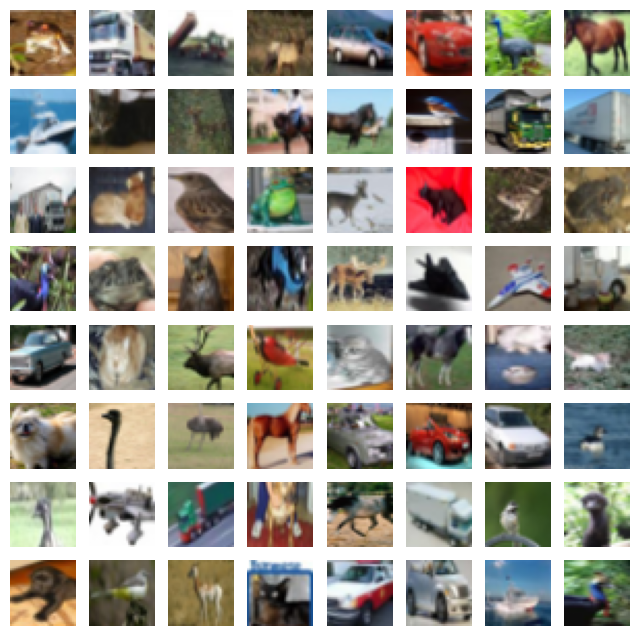

In [ ]:
trainloader_not_shuffle = DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

plot_CIFAR_grid(trainloader_not_shuffle, N=8, unnormalize=True)

### Давайте снова обучим нашу модель на аугментированных данных.

In [ ]:
model = SimpleVGG(n_classes=len(classes))
optimizer = torch.optim.NAdam(model.parameters(), lr=5e-4)
criterion = torch.nn.CrossEntropyLoss()
model.to(device)
num_epochs = 30
train_history, test_history = train_model(model, trainloader, testloader, optimizer, num_epochs)

Epoch 1/30
Loss: 1.6888 | Train Accuracy: 0.3926 | Test Accuracy: 0.4946
Epoch 2/30
Loss: 1.3466 | Train Accuracy: 0.5188 | Test Accuracy: 0.5549
Epoch 3/30
Loss: 1.1984 | Train Accuracy: 0.5724 | Test Accuracy: 0.6088
Epoch 4/30
Loss: 1.0914 | Train Accuracy: 0.6127 | Test Accuracy: 0.6509
Epoch 5/30
Loss: 1.0170 | Train Accuracy: 0.6388 | Test Accuracy: 0.6385
Epoch 6/30
Loss: 0.9580 | Train Accuracy: 0.6622 | Test Accuracy: 0.6850
Epoch 7/30
Loss: 0.9095 | Train Accuracy: 0.6819 | Test Accuracy: 0.6821
Epoch 8/30
Loss: 0.8673 | Train Accuracy: 0.6960 | Test Accuracy: 0.6971
Epoch 9/30
Loss: 0.8298 | Train Accuracy: 0.7076 | Test Accuracy: 0.6859
Epoch 10/30
Loss: 0.7954 | Train Accuracy: 0.7195 | Test Accuracy: 0.7251
Epoch 11/30
Loss: 0.7620 | Train Accuracy: 0.7349 | Test Accuracy: 0.7325
Epoch 12/30
Loss: 0.7368 | Train Accuracy: 0.7436 | Test Accuracy: 0.7369
Epoch 13/30
Loss: 0.7126 | Train Accuracy: 0.7518 | Test Accuracy: 0.7306
Epoch 14/30
Loss: 0.6872 | Train Accuracy: 0.76

Построим графики точности на тестовой и трейновой выборках в конце каждой эпохи обучения.

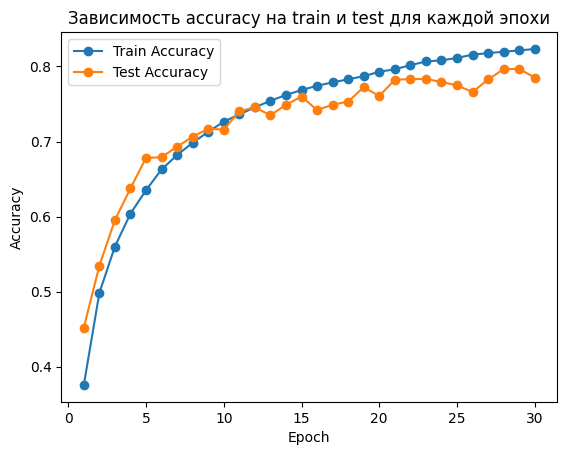

In [ ]:
plt.plot(range(1, len(train_history)+1), train_history, label='Train Accuracy', marker="o")
plt.plot(range(1, len(test_history)+1), test_history, label='Test Accuracy', marker="o")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Зависимость accuracy на train и test для каждой эпохи")
plt.legend()
plt.show()

## 2)*  Бонус: Переобучение. Изменение нейронной сети

### Dropout

Dropout - техника борьбы с переобучением, при которой в процессе тренировки случайно "выключаются" некоторые нейроны из моделей.

Альтернативный взгляд - вместо тренировки одной большой сети проходит одновременная тренировка нескольких подсетей меньшего размера, результаты которых потом усредняются (в каком то смысле, сглаживаются).


<img src="https://github.com/MerkulovDaniil/TensorFlow_and_Keras_crash_course/blob/master/rus/2_Deep%20Learning%20and%20Keras/dropout.gif?raw=true"
     width="500" align="center" alt="Принцип работы Dropout" >

Такой слой тоже реализован в библиотеке `torch`. Давайте добавим его в нашу модель

In [ ]:
class SimpleVGG(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        #VGG1-блок
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            # Слой dropout, который "выключает" 20% случайно выбранных нейронов
            nn.Dropout2d(0.2)
        )

        #VGG2-блок
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Dropout2d(0.2)
        )

        # Блок классификатора
        self.classifier = nn.Sequential(
            # Разворачиваем данные в вектор
            nn.Flatten(),
            nn.Linear(in_features=8*8*64, out_features=64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=64, out_features=n_classes),

        )

    # Последовательно подаем входные данные через 2 VGG слоя и классификатор
    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.classifier(out)
        return out

### Batch Normalization

Помимо нормализации входных данных часто используют нормализацию данных по батчам внутри модели после некоторых слоёв.

Батч-нормализация – это метод нормализации данных в нейронных сетях, который позволяет улучшить процесс обучения и повысить его стабильность. Этот подход является одним из ключевых инструментов в области глубокого обучения.

Основная идея батч-нормализации заключается в том, чтобы привести распределение активаций каждого слоя нейронной сети к некоторой стандартной форме. Для этого во время обучения происходит вычисление среднего значения и дисперсии активаций внутри каждого батча данных.


<table>
  <tr>
    <td>
      <img src="https://images.deepai.org/glossary-terms/981e1ffea3814ae193c27461253faf63/batch_normalization.png" alt=" Batch Normalization 1" width="600">
    </td>
    <td>
      <img src="https://habrastorage.org/r/w1560/files/005/d19/2bd/005d192bd6274c298f75896498aea377.png" alt=" Batch Normalization 2" width="400">
    </td>
  </tr>
</table>

#### Задача 2. BatchNorm

<!-- Добавьте слой батч-нормализации в нашу модель. -->

Слой батч-нормализации задается следующим способом : `nn.BatchNorm2d({Количество каналов})`, где **{Количество каналов}** должно быть равным **количеству выходных каналов с предыдущего слоя**.

Добавьте слой нормализации после каждого слоя свертки (Conv2d) в каждом из **VGG блоков** нашей модели.


In [ ]:
### Допишите ячейку с кодом

class SimpleVGG(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        #VGG1-блок
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Dropout2d(0.2)
        )

        #VGG2-блок
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Dropout2d(0.2)
        )

        # Блок классификатора
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=8*8*64, out_features=64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(in_features=64, out_features=n_classes),

        )

    # Последовательно подаем входные данные через 2 VGG слоя и классификатор
    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.classifier(out)
        return out

**Давайте снова воспользуемся помощью Мистраля:**


Добавьте слой нормализации после каждого слоя свертки (Conv2d) в каждом из VGG блоков нашей модели.

```bash
class SimpleVGG(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        #VGG1-блок
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Dropout2d(0.2)
        )

        #VGG2-блок
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Dropout2d(0.2)
        )

        # Блок классификатора
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=8*8*64, out_features=64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(in_features=64, out_features=n_classes),

        )

    # Последовательно подаем входные данные через 2 VGG слоя и классификатор
    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.classifier(out)
        return out
```

In [ ]:
class SimpleVGG(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        #VGG1-блок
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Dropout2d(0.2)
        )

        #VGG2-блок
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Dropout2d(0.2)
        )

        # Блок классификатора
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=8*8*64, out_features=64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(in_features=64, out_features=n_classes),
        )

    # Последовательно подаем входные данные через 2 VGG слоя и классификатор
    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.classifier(out)
        return out
### Ваш ответ

Если вы добавили слой 4 раза, то попробуйте запустить эту ячейку и проверить, правильно ли вы подсчитали количество каналов в BatchNorm. Если количество каналов написано правильно, то ячейка выдаст тензор - выход нейронной сети

In [ ]:
test_input = torch.rand(1,3,32,32)
model = SimpleVGG(n_classes=10)
model(test_input)

tensor([[ 0.0824, -0.0280, -0.0149, -0.0249, -0.0683, -0.3139, -0.2951,  0.0418,
         -0.4297, -0.4978]], grad_fn=<AddmmBackward0>)

### Давайте снова обучим нашу модель со слоями Dropout и BatchNorm.

In [ ]:
model = SimpleVGG(n_classes=len(classes))
optimizer = torch.optim.NAdam(model.parameters(), lr= 5e-4)
criterion = torch.nn.CrossEntropyLoss()
model.to(device)
num_epochs = 30
train_history, test_history = train_model(model, trainloader, testloader, optimizer, num_epochs)

Epoch 1/30
Loss: 1.5721 | Train Accuracy: 0.4280 | Test Accuracy: 0.5384
Epoch 2/30
Loss: 1.2755 | Train Accuracy: 0.5434 | Test Accuracy: 0.6101
Epoch 3/30
Loss: 1.1491 | Train Accuracy: 0.5911 | Test Accuracy: 0.6631
Epoch 4/30
Loss: 1.0692 | Train Accuracy: 0.6193 | Test Accuracy: 0.6924
Epoch 5/30
Loss: 1.0152 | Train Accuracy: 0.6431 | Test Accuracy: 0.6973
Epoch 6/30
Loss: 0.9685 | Train Accuracy: 0.6582 | Test Accuracy: 0.6931
Epoch 7/30
Loss: 0.9303 | Train Accuracy: 0.6710 | Test Accuracy: 0.7309
Epoch 8/30
Loss: 0.9026 | Train Accuracy: 0.6803 | Test Accuracy: 0.7181
Epoch 9/30
Loss: 0.8780 | Train Accuracy: 0.6899 | Test Accuracy: 0.7193
Epoch 10/30
Loss: 0.8586 | Train Accuracy: 0.6990 | Test Accuracy: 0.7409
Epoch 11/30
Loss: 0.8358 | Train Accuracy: 0.7073 | Test Accuracy: 0.7445
Epoch 12/30
Loss: 0.8227 | Train Accuracy: 0.7113 | Test Accuracy: 0.7329
Epoch 13/30
Loss: 0.8017 | Train Accuracy: 0.7186 | Test Accuracy: 0.7365
Epoch 14/30
Loss: 0.7867 | Train Accuracy: 0.72

Построим графики точности на тестовой и трейновой выборках в конце каждой эпохи обучения.

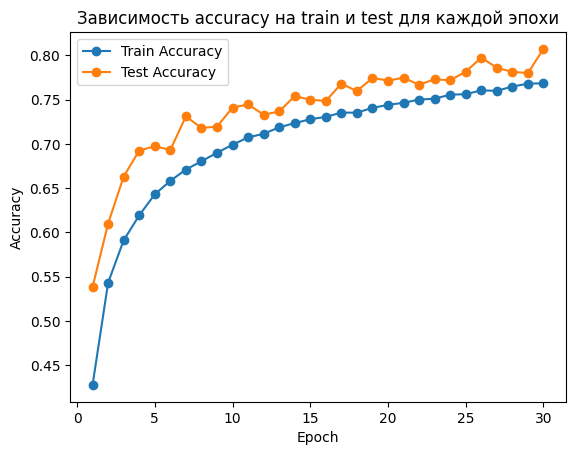

In [ ]:
plt.plot(range(1, len(train_history)+1), train_history, label='Train Accuracy', marker="o")
plt.plot(range(1, len(test_history)+1), test_history, label='Test Accuracy', marker="o")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Зависимость accuracy на train и test для каждой эпохи")
plt.legend()
plt.show()

### Вывод

Аугментация тренировочной выборки, Dropout и BatchNorm слои модели положительно влияют на обобщающую способность сети, позволяя нейросети улавливать свойства целого класса, а не небольшой выборки тренировочных данных.

## 3. Бонус. Transfer learning

Использование предобученных моделей для новых задач.

Как уже упоминалось ранее, есть архитектуры нейросетей, которые зарекомендовали себя в решении определенного класса задач, как, например, **VGG16**.

<img src="https://www.researchgate.net/profile/Timea-Bezdan/publication/333242381/figure/fig2/AS:760979981860866@1558443174380/VGGNet-architecture-19.ppm" width="400" align="center" alt="Архитектура сети VGG">

<img src="https://upload.wikimedia.org/wikipedia/commons/2/24/VGG16.png" width="600" align="center" alt="Архитектура сети VGG">


**VGG16** и подобные ей модели содержат большое количество параметров и обучение их с нуля может занять большое количество времени.

Кроме того, бывают задачи, где данных изначально небольшое количество и даже аугментация не сильно спасает положение, тогда обучение сверточной сети может не быть очень успешным.

Последний слой большинства нейронных сетей для классификации можно трактовать как обычную логистическую регрессию. Получается, что промежуточные слои нейронной сети формируют некоторое информативное представление данных, которое упрощает принятие решения моделью на последнем слое. Таким образом, мы можем использовать уже обученную модель чтобы получить информативное представление наших данных, и затем дать его на вход нашей небольшой простой модели.

Часто используют модель, которая уже была кем-то предобучена - загружают ее веса и дообучают только последние слои, подстраивая их под свою конкретную задачу!

#### План работы:

1.  Загрузить предобученную VGG16 модель
2.  Изменить нейронную сеть под нашу задачу

### 1) Загрузить предобученную VGG16 модель

В библиотеке `torch` уже представлены архитектуры **State-of-the-art** моделей, поэтому можно достать **VGG16** модель одной строчкой кода.

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16_bn', pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:07<00:00, 72.9MB/s]


Посмотрим, из чего состоит VGG16

In [ ]:
summary(model, (3, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

Как мы видим, модель состоит из 2 основных частей: блоков **features** и **classifier**

Блок **features** отвечает за то, чтобы получить признаки из изображения. Затем эти признаки поступят на вход в блок **classifier**, где уже будет происходить классификация изображения на классы по признакам.\
Заметим, что последний линейный слой в **classifier** имеет 1000 классов на выходе. Это потому, что нейронная сеть была предобучена на датасете ImageNet, который содержит 1000 классов.

**Вопрос** А сможем ли мы использовать предобученную нейронную сеть на нашей задаче, где всего 10 классов?

### 2) Пишем свой classifier

In [ ]:
### Решение
vgg_classifier = nn.Sequential(
    ### Ваш код здесь
)

**Промт для Мистраля:**

Перепиши данный блок классификатора так, чтобы на выходе было 10 классов и присвой его переменной *vgg_classifier*.

Код:

```bash
(classifier): Sequential(
    (0): Linear(in_features=25088, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=4096, out_features=1000, bias=True)
  )
```

In [ ]:
vgg_classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=10, bias=True),
)
### Ваш ответ

Если вы все правильно написали, то ячейка запустится и выдаст количество классов, которое будет предсказывать модель (в нашем случае - 10)

In [ ]:
model.classifier = vgg_classifier
test_input = torch.rand(1,3,224,224)
model(test_input).shape[1]

10

### 2)* Способ проще

Возьмем последний слой по индексу, и заменим его на другой с нашими параметрами

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16_bn', pretrained=True)
model.classifier[6] = nn.Linear(in_features=4096, out_features=10)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


### Бонус*: 3. Заморозка параметров сети

Если мы просто начнем обучать всю нейронную сеть, то изменим **всю** заранее обученную модель во время процесса тренировки.\
Казалось бы, что в этом нет ничего плохого. Проблема заключается в том, что значения переменных на последнем слое классификации будут заполненны случайными значениями и из-за этого наша модель будет допускать большие ошибки, что, в свою очередь, повлечёт сильные изменения исходных весов в предобученной модели, что крайне нежелательно для нас.

Решение заключается в отключении обучения переменных предобученной модели — мы просто запретим алгоритму их менять.
Этот процесс называется "заморозкой модели" (freezing the model).


<img src="https://res.cloudinary.com/practicaldev/image/fetch/s--TP0yYJqp--/c_limit%2Cf_auto%2Cfl_progressive%2Cq_auto%2Cw_880/https://i.ibb.co/KwhsJYg/pretrained-model-last.png" width="400" align="center" alt="Freezing the model">

In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
for param in model.features.parameters():
    param.require_grad = False

### Посмотрим на результат работы VGG16

In [ ]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
device

'cuda'

In [ ]:
optimizer = torch.optim.NAdam(model.parameters(), lr= 3e-4)
criterion = torch.nn.CrossEntropyLoss()
model.to(device)
num_epochs = 5
train_history, test_history = train_model(model, trainloader, testloader, optimizer, num_epochs)

Epoch 1/5
Loss: 0.7015 | Train Accuracy: 0.7728 | Test Accuracy: 0.8440
Epoch 2/5
Loss: 0.4309 | Train Accuracy: 0.8609 | Test Accuracy: 0.8727
Epoch 3/5
Loss: 0.3427 | Train Accuracy: 0.8902 | Test Accuracy: 0.8588
Epoch 4/5
Loss: 0.2980 | Train Accuracy: 0.9040 | Test Accuracy: 0.8804
Epoch 5/5
Loss: 0.2543 | Train Accuracy: 0.9170 | Test Accuracy: 0.8681


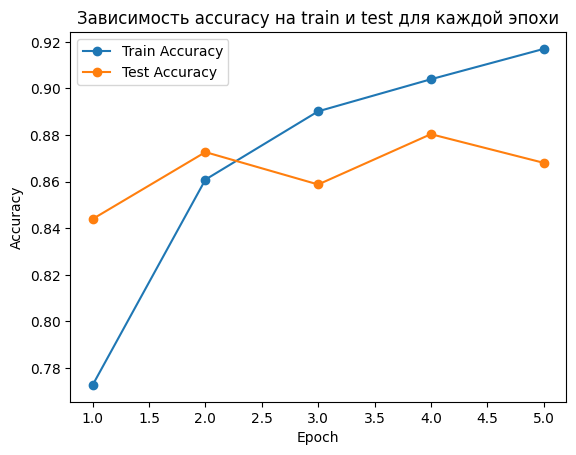

In [ ]:
plt.plot(range(1, len(train_history)+1), train_history, label='Train Accuracy', marker="o")
plt.plot(range(1, len(test_history)+1), test_history, label='Test Accuracy', marker="o")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Зависимость accuracy на train и test для каждой эпохи")
plt.legend()
plt.show()

Использование предобученной модели **VGG** уже с 1й эпохи позволило нейросети достичь точности $>81$% на тестовой выборке!

Текущий результат сильно превосходит бейзлайн и позволяет на его основе строить еще более мощные предсказательные модели.

## Выводы


1.   Мы обучили сверточную нейросеть на датасете из цветных фото из $10$ классов - **CIFAR10**

2.   Познакомились с сущностями `Dataset` и `Dataloader`, которые позволяют доставлять данные в модель.

3.   Использовали **аугментированные**  данные для преодоления переобучения модели

4.   Узнали о других способах борьбы с переобучением, как  **BatchNormalization** и **Dropout**

5.   Познакомились со **state-of-the-art** моделью для вытаскивания признаков из картинок - **VGG16**

6.   Узнали, что такое **transfer learning**, использовали предобученную **VGG16** модель для создания своего классификатора, достигли точности $>85$% на тестовой выборке.